In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
from sklearn.model_selection import StratifiedKFold
import anndata as ad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = '#3d405b'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# D0

In [3]:
rna = ad.read_h5ad('/home/mffang/data/counts/Klein_2015/SRR1784310/counts_unfiltered/adata.h5ad')
rna

AnnData object with n_obs × n_vars = 142237 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

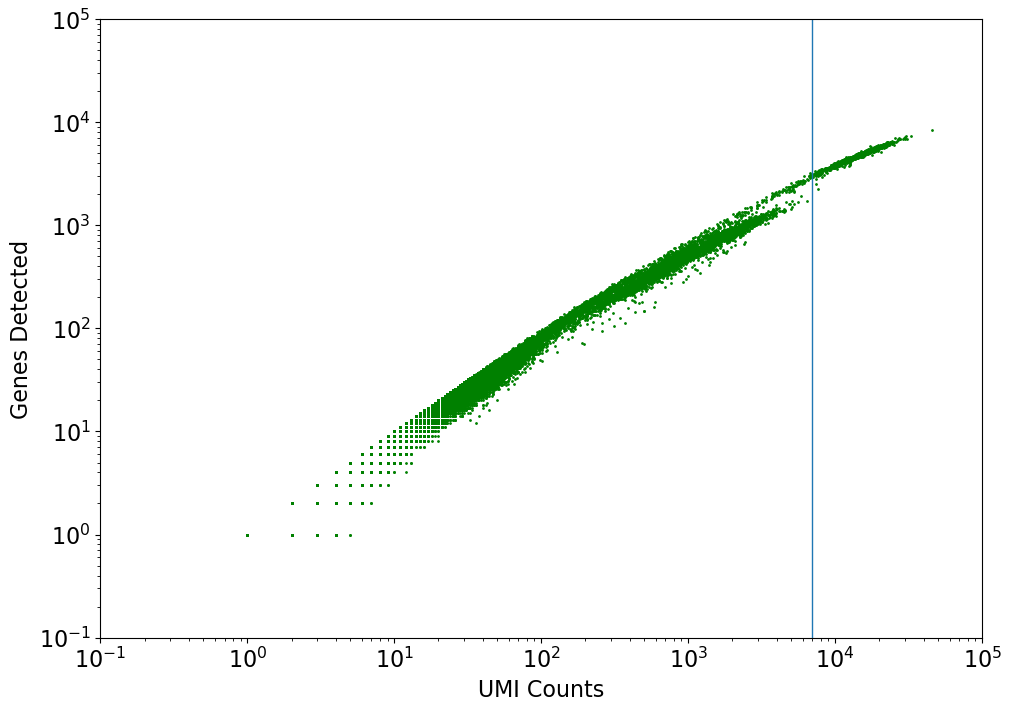

In [4]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=1, s=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=7000,linewidth=1)
plt.show()

In [5]:
adata = rna[np.asarray(mtx.sum(axis=1))>7000]
adata

View of AnnData object with n_obs × n_vars = 875 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

In [6]:
adata.layers['spliced'] = adata.layers['mature'] + adata.layers['ambiguous']
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

,gene_id
ENSMUSG00000100764,ENSMUSG00000100764.2
ENSMUSG00000100635,ENSMUSG00000100635.2
ENSMUSG00000100480,ENSMUSG00000100480.2
ENSMUSG00000051285,ENSMUSG00000051285.18
ENSMUSG00000097797,ENSMUSG00000097797.7
...,...
ENSMUSG00000094799,ENSMUSG00000094799.2
ENSMUSG00000095019,ENSMUSG00000095019.2
ENSMUSG00000094915,ENSMUSG00000094915.2
ENSMUSG00000079808,ENSMUSG00000079808.4


## Compare

In [42]:
their_adata = ad.read_h5ad('data/velocity_anndata_mouse_embryonic_stem_cells_DeepCycle_ISMARA.h5ad')
their_adata.var_names_make_unique
their_barcodes = np.array([bc[-17:-1] for bc in their_adata.obs_names])

tenx = ad.read_h5ad('/home/mffang/data/counts/DeepCycle_2020/mESC/counts_filtered/adata.h5ad')

cell_idx = [np.where(tenx.obs_names==bc)[0][0] for bc in their_barcodes]
tenx = tenx[cell_idx]
tenx.var['gene_id'] = tenx.var_names
tenx.var_names = [g.split('.')[0] for g in tenx.var_names]

/tmp/ipykernel_884559/1203830793.py:9: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tenx.var['gene_id'] = tenx.var_names


/tmp/ipykernel_884559/1658318905.py:5: RuntimeWarning: invalid value encountered in divide
  y = (tenx_.layers['mature'].toarray().var(0)/tenx_.layers['mature'].toarray().mean(0)-1)/tenx_.layers['mature'].toarray().mean(0)


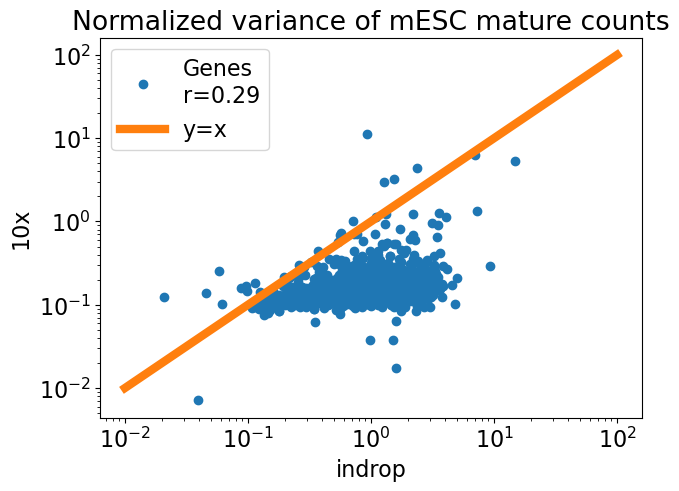

In [67]:
nonzero_idx = adata.layers['mature'].toarray().mean(0)>0.1
gene_idx = [np.where(tenx.var_names==g)[0][0] for g in adata.var_names[nonzero_idx]]
tenx_ = tenx[:,gene_idx]
x = (adata.layers['mature'].toarray()[:,nonzero_idx].var(0)/adata.layers['mature'].toarray()[:,nonzero_idx].mean(0)-1)/adata.layers['mature'].toarray()[:,nonzero_idx].mean(0)
y = (tenx_.layers['mature'].toarray().var(0)/tenx_.layers['mature'].toarray().mean(0)-1)/tenx_.layers['mature'].toarray().mean(0)
x_masked = np.ma.masked_invalid(x)
y_masked = np.ma.masked_invalid(y)
corr_value = np.around(np.ma.corrcoef(x_masked, y_masked)[0, 1], 2)

plt.loglog(x,y,'.',label='Genes\n'+'r=' + str(corr_value))
plt.plot([0.01,100],[0.01,100],label='y=x')
plt.xlabel('indrop')
plt.ylabel('10x')
plt.title('Normalized variance of mESC mature counts')
plt.legend()

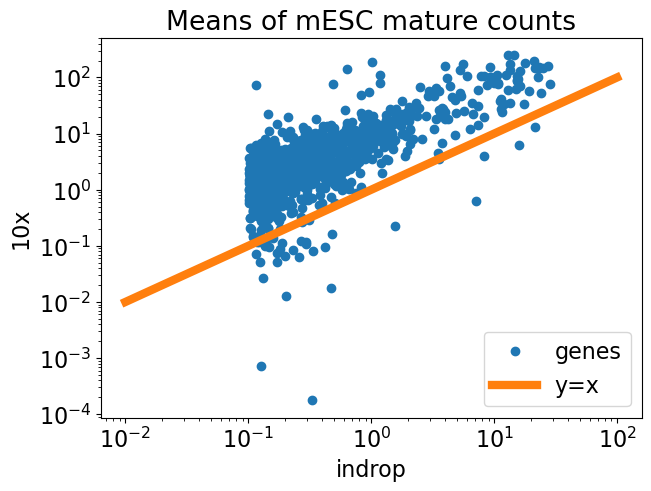

In [54]:
plt.loglog(adata.layers['mature'].toarray()[:,nonzero_idx].mean(0),tenx_.layers['mature'].toarray().mean(0),'.',label='genes')
plt.plot([0.01,100],[0.01,100],label='y=x')
plt.xlabel('indrop')
plt.ylabel('10x')
plt.title('Means of mESC mature counts')
plt.legend()

## Check gene expression of two marker genes

In [6]:
adata.var['gene'] = [id.split('.')[0] for id in adata.var_names]

/tmp/ipykernel_3687010/2173498562.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene'] = [id.split('.')[0] for id in adata.var_names]


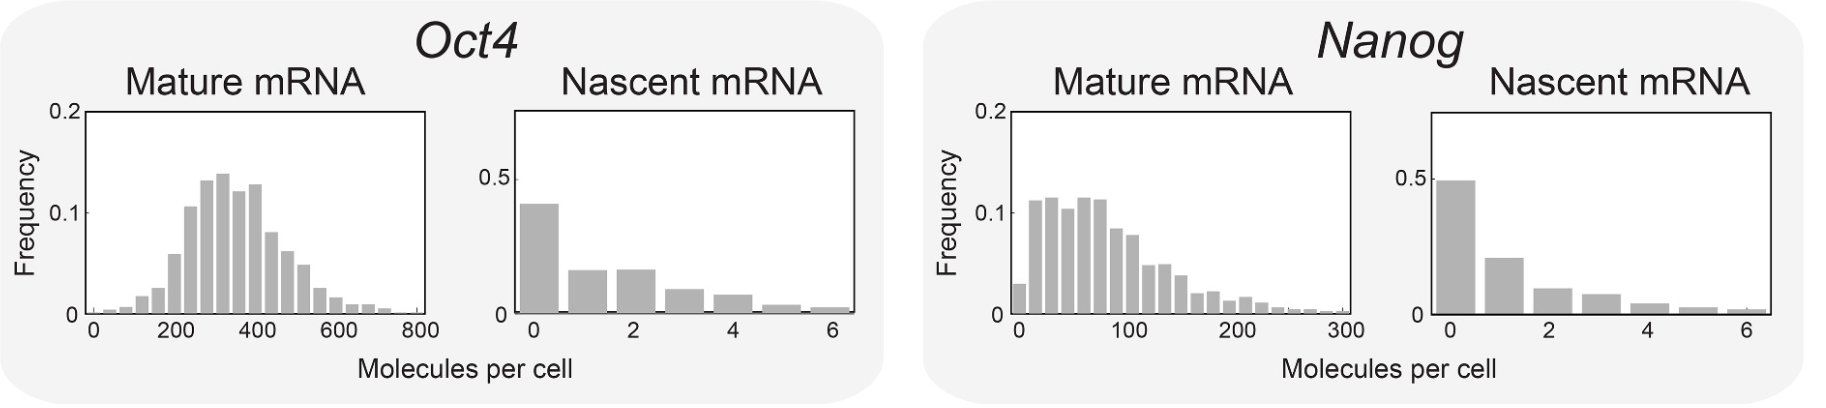

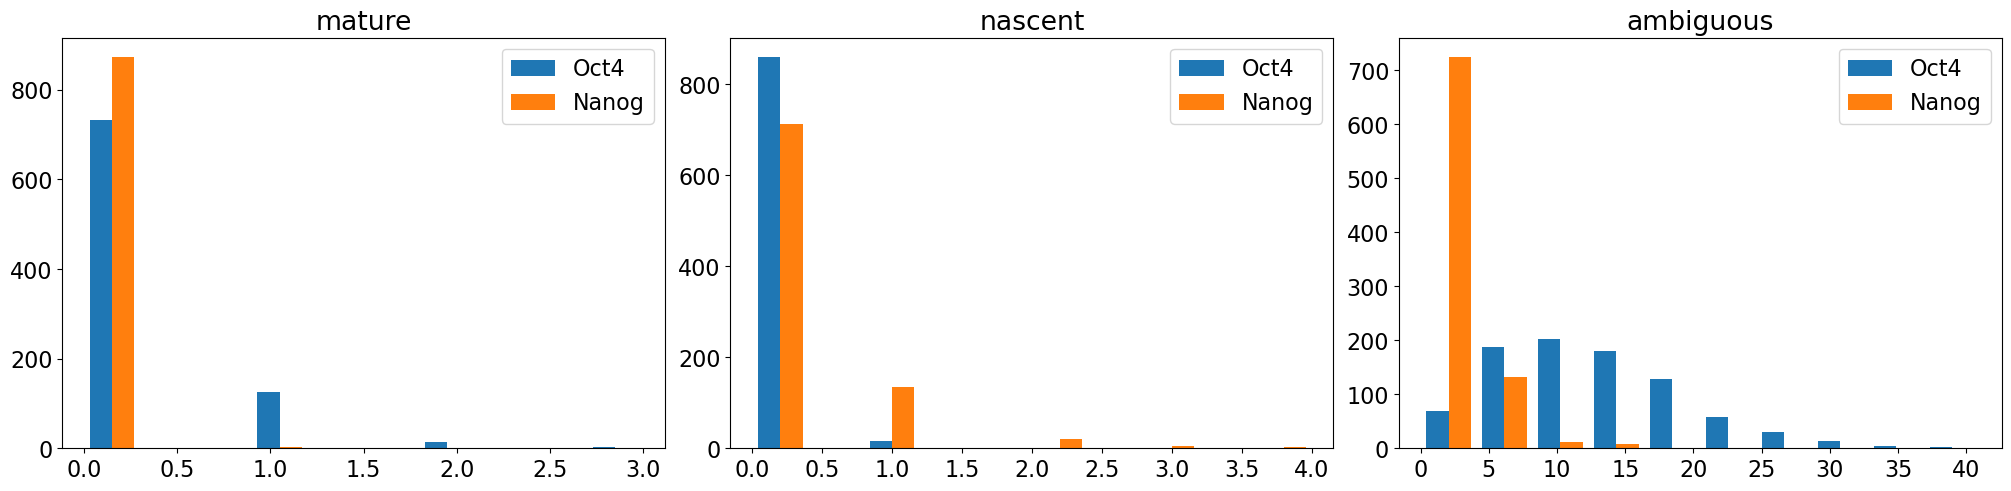

In [7]:
fig, axs = plt.subplots(1,3,figsize=(20,4.8))
axs[0].hist(adata.layers["mature"].toarray()[:,adata.var["gene"].isin(["ENSMUSG00000024406","ENSMUSG00000012396"])],label=['Oct4','Nanog']);
axs[1].hist(adata.layers["nascent"].toarray()[:,adata.var["gene"].isin(["ENSMUSG00000024406","ENSMUSG00000012396"])],label=['Oct4','Nanog']);
axs[2].hist(adata.layers["ambiguous"].toarray()[:,adata.var["gene"].isin(["ENSMUSG00000024406","ENSMUSG00000012396"])],label=['Oct4','Nanog']);

axs[0].set_title('mature')
axs[1].set_title('nascent')
axs[2].set_title('ambiguous')

for i in range (3):
    axs[i].legend()

## Calculate extrinsic noise

0.16843958 0.041063856 0.22395986


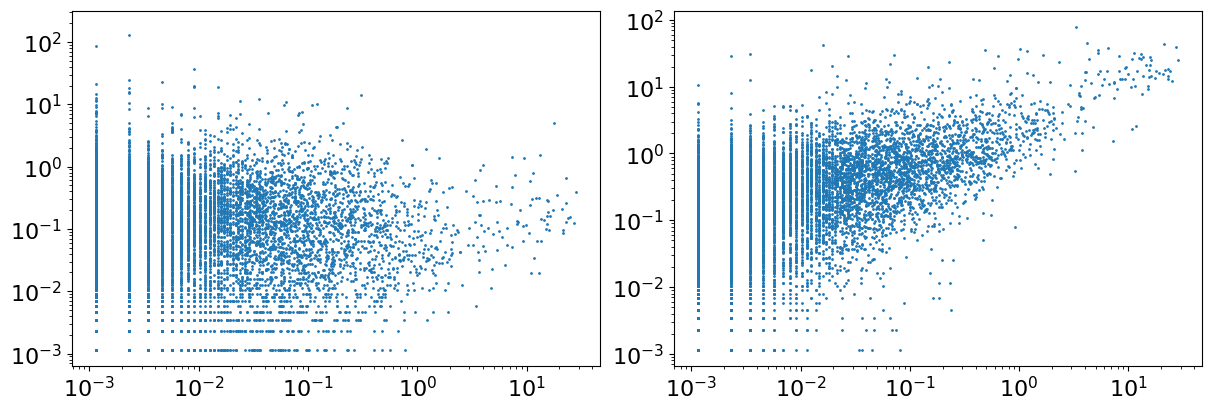

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

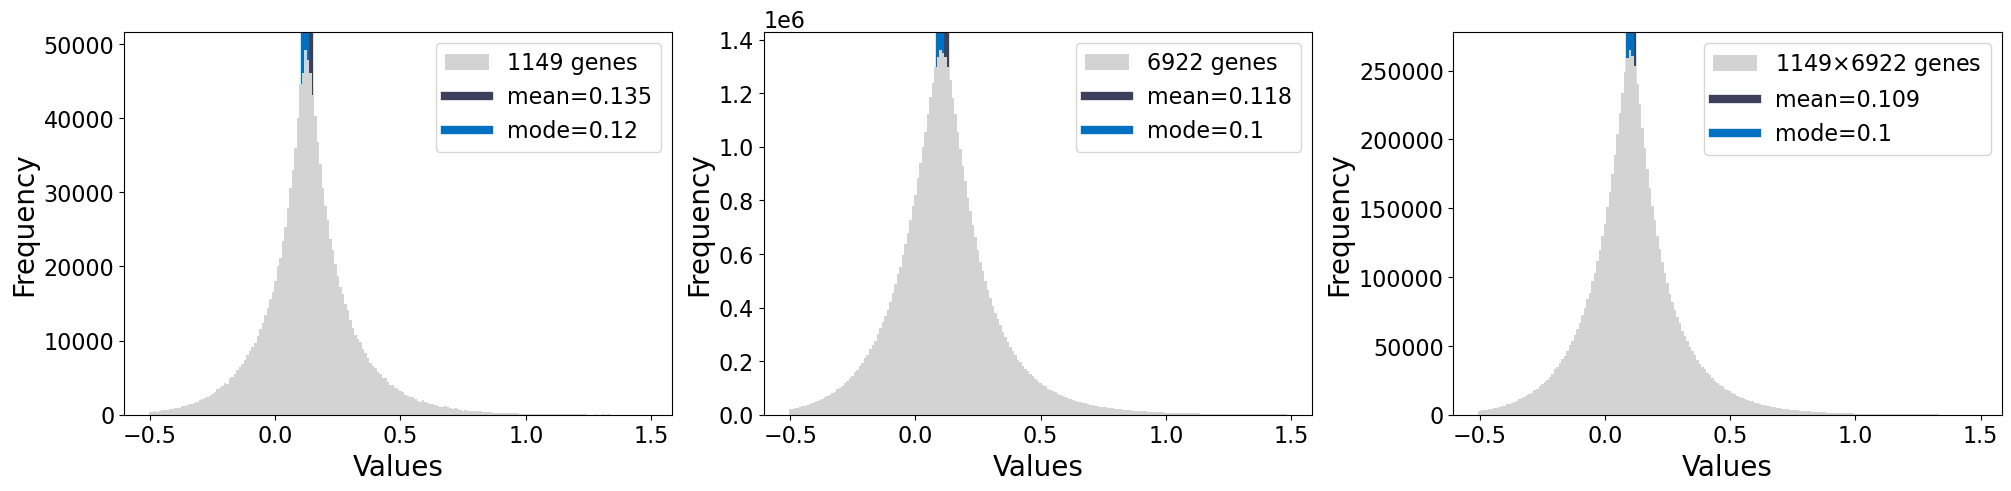

In [7]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

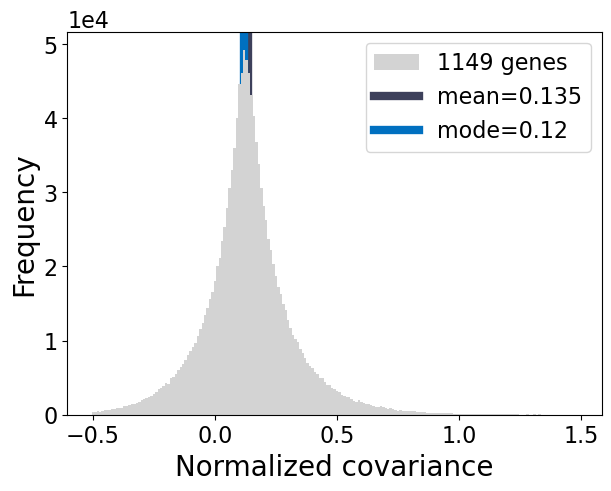

In [10]:
fig,axs = plt.subplots(1,1,figsize=(6,4.8))
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

## Variance

In [20]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

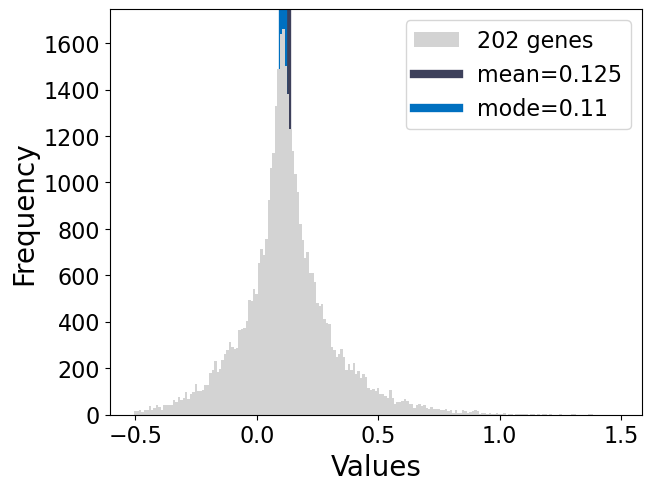

In [21]:
s = 0.12
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['mature'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

In [22]:
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

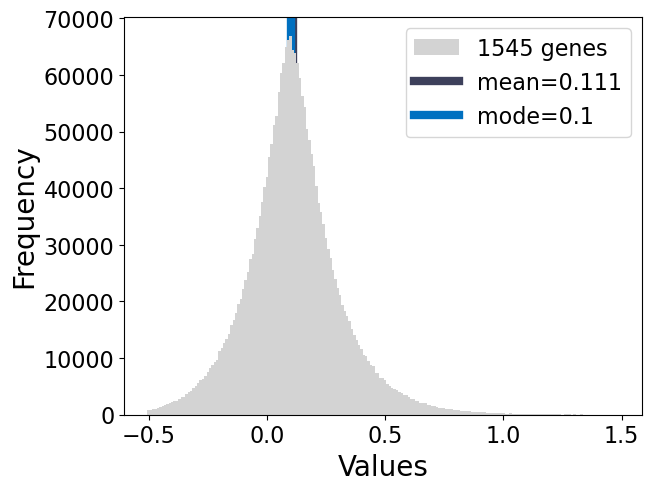

In [23]:
s = 0.1
U_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers['nascent'].toarray()[:,idx]
_ = estimate_s(X_U,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

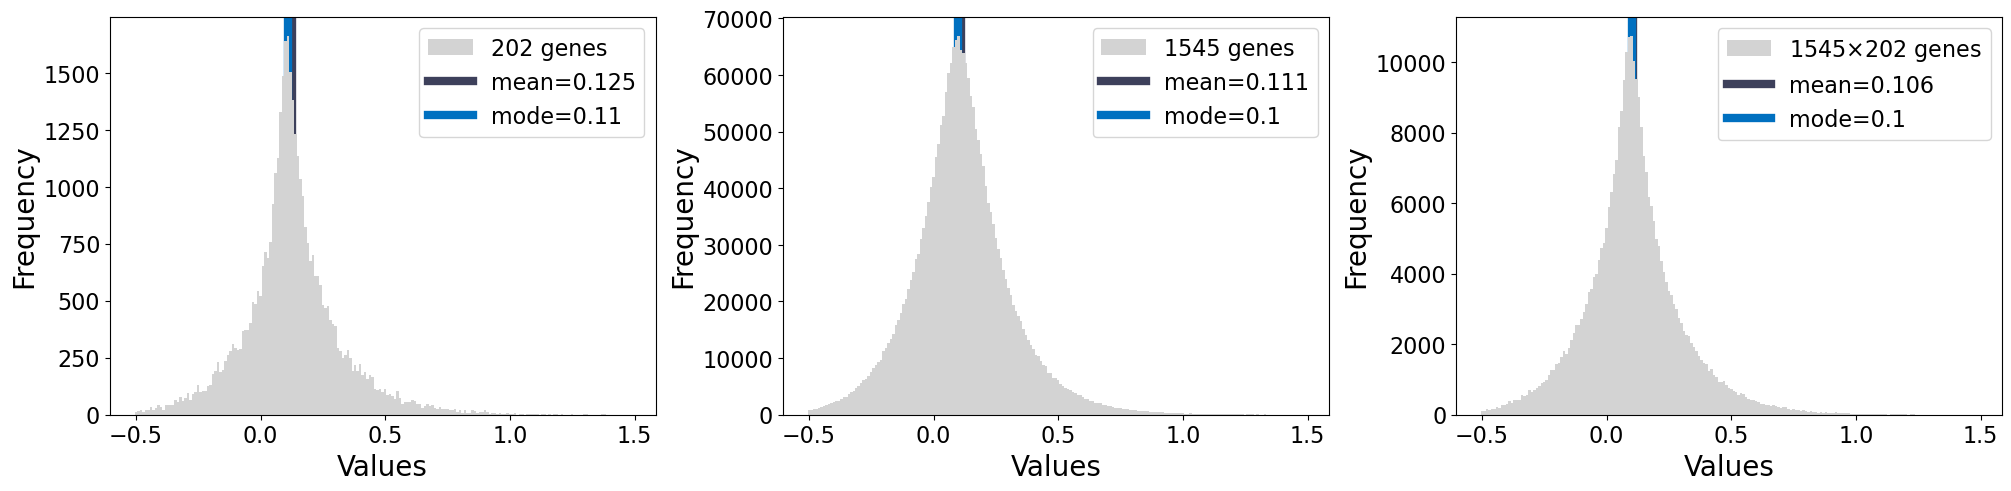

In [24]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=0.1)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=0.1)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=0.1)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

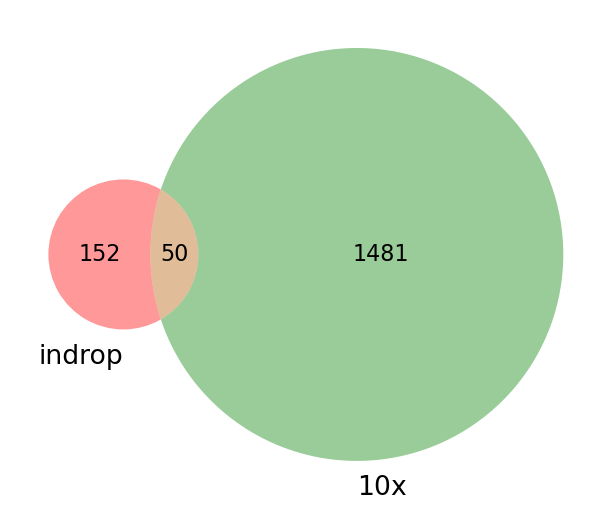

In [34]:
from matplotlib_venn import venn2

other_Pgenes = np.loadtxt("results/mESC_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(other_Pgenes)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, other_Pgenes_set], set_labels=('indrop', '10x'))
plt.show()

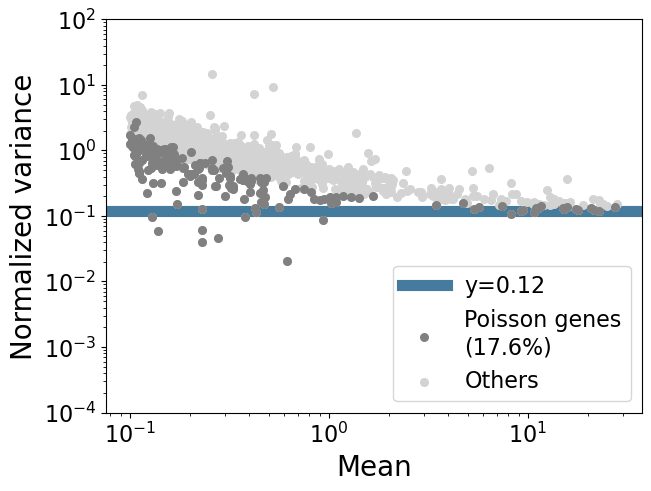

In [26]:
s = 0.12
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

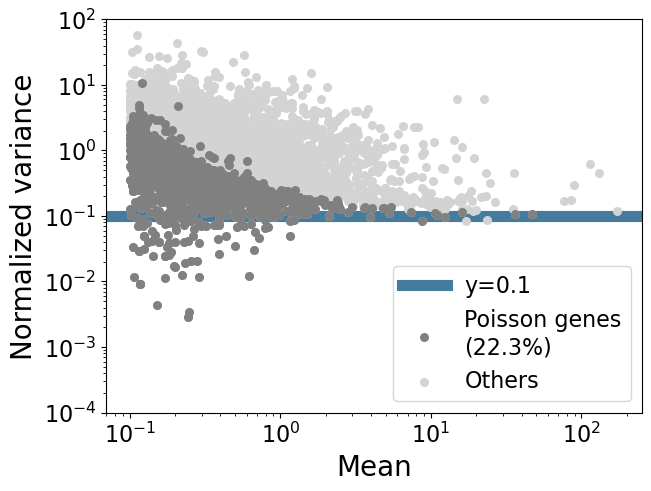

In [27]:
s = 0.1
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = U_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

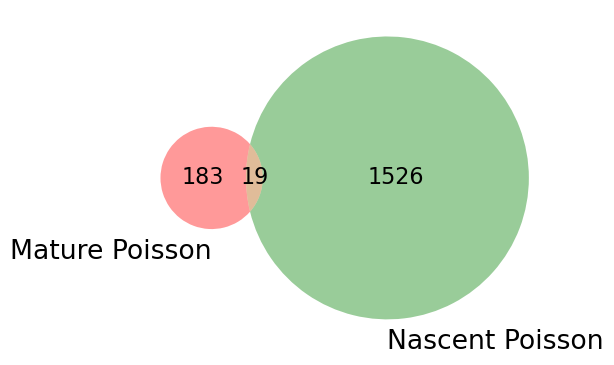

In [32]:
# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(U_Pgene)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, other_Pgenes_set], set_labels=('Mature Poisson', 'Nascent Poisson'))

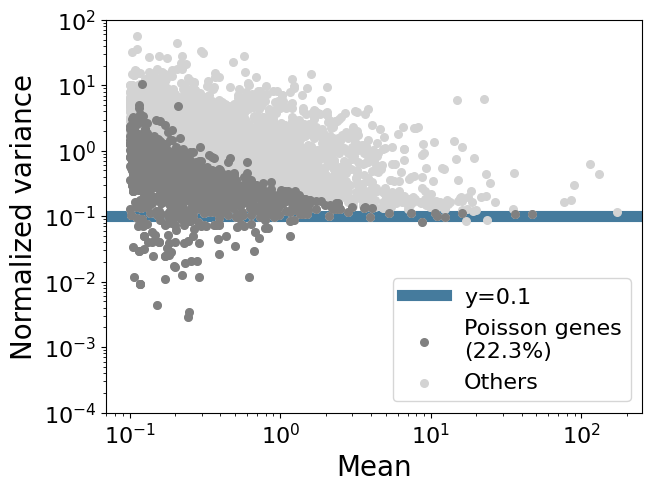

In [14]:
s = su
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = U_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [61]:
D0_Pgenes = S_Pgene.copy()
D0_Pgenes

Index(['ENSMUSG00000039630.11', 'ENSMUSG00000062169.14',
       'ENSMUSG00000026019.16', 'ENSMUSG00000061518.12',
       'ENSMUSG00000073702.12', 'ENSMUSG00000079283.3', 'ENSMUSG00000098234.9',
       'ENSMUSG00000006299.14', 'ENSMUSG00000020075.9', 'ENSMUSG00000093674.8',
       ...
       'ENSMUSG00000032803.16', 'ENSMUSG00000032212.11',
       'ENSMUSG00000104208.2', 'ENSMUSG00000015656.18',
       'ENSMUSG00000038717.10', 'ENSMUSG00000032518.7',
       'ENSMUSG00000062070.13', 'ENSMUSG00000057421.13',
       'ENSMUSG00000041133.12', 'ENSMUSG00000008682.14'],
      dtype='object', name='gene_id', length=202)

r=0.97


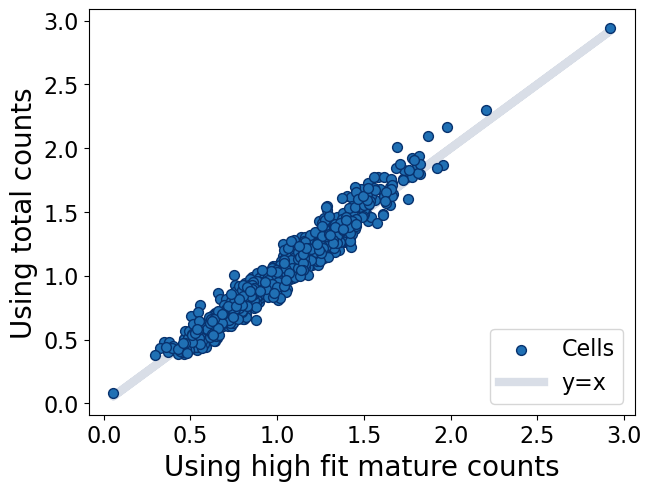

In [37]:
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)
cellsize_S = cellsize_S/cellsize_S.mean()
cellsize_X = adata.X.toarray().copy().sum(1)

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()


fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(cellsize_S,cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(cellsize_S,cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using high fit mature counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

## Simulation check

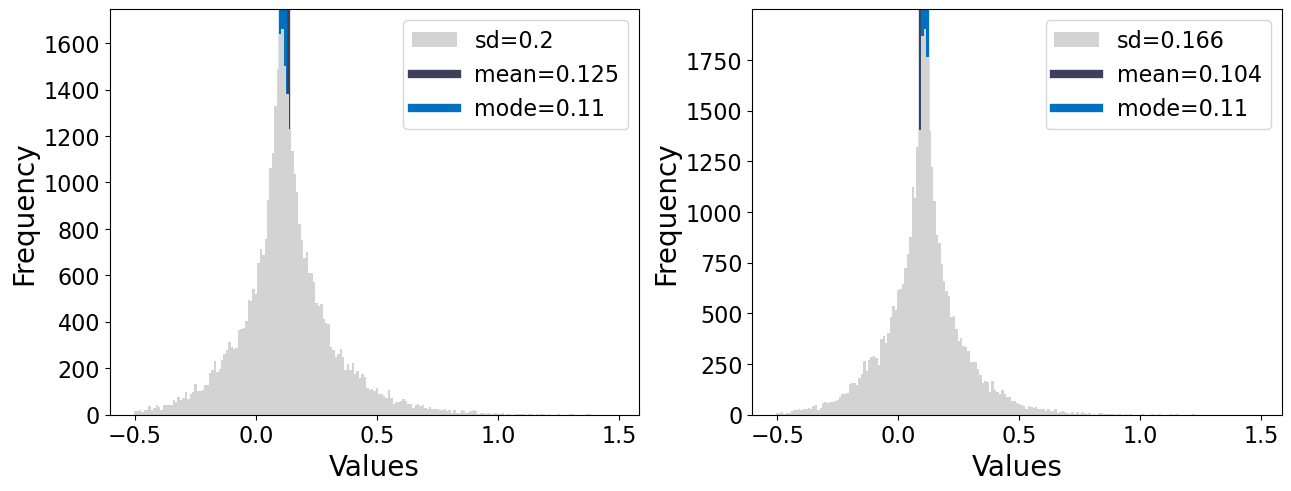

In [74]:
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
np.random.seed(2025)
XX = np.random.poisson(c[:,None]*lam[None,:])

fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=XX,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

## Check covariance relationships

In [85]:
U_genes = adata.var_names[adata.layers["nascent"].toarray().mean(0) > 0.1][~U_Pgene_mask]
S_genes = adata.var_names[adata.layers["mature"].toarray().mean(0) > 0.1][~S_Pgene_mask]
cov_genes = np.append(U_genes,S_genes)
cov_genes = U_genes[U_genes.isin(S_genes)]
len(U_genes),len(S_genes),U_genes.isin(S_genes).sum()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


(1320, 192, 18)

In [26]:
s_ss = 0.12
s_us = 0.1

idx = adata.var_names.isin(adata.var_names)

U = adata.layers["nascent"][:,idx].toarray()
S =  adata.layers["mature"][:,idx].toarray() 

idx = (U.mean(0)>0.1) & (S.mean(0)>1)
U = U[:,idx]
S = S[:,idx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2-s
zeta_ss = (S_var-S_mean)/S_mean**2-s_ss

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = cov_us/S_mean/U_mean-s_us
zeta_us.shape

(87,)

## Var(N_U)

Text(0.5, 1.0, '84.62% of cells >= 0')

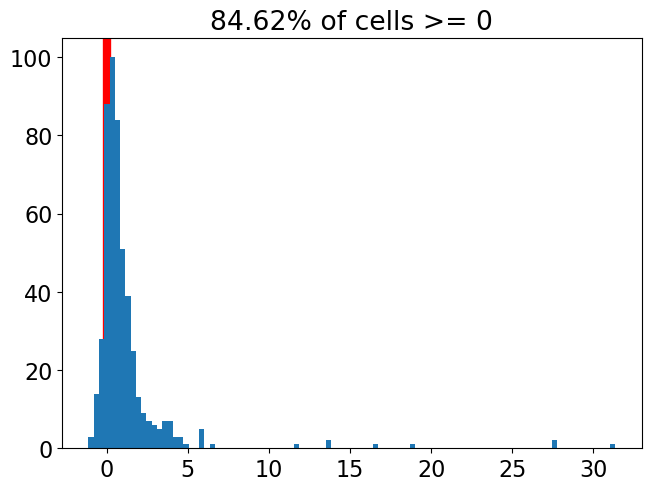

In [9]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

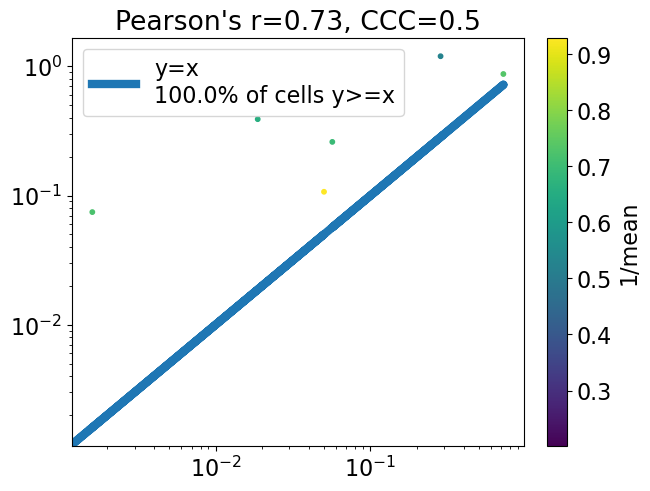

In [17]:
x=zeta_us
y=zeta_uu

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

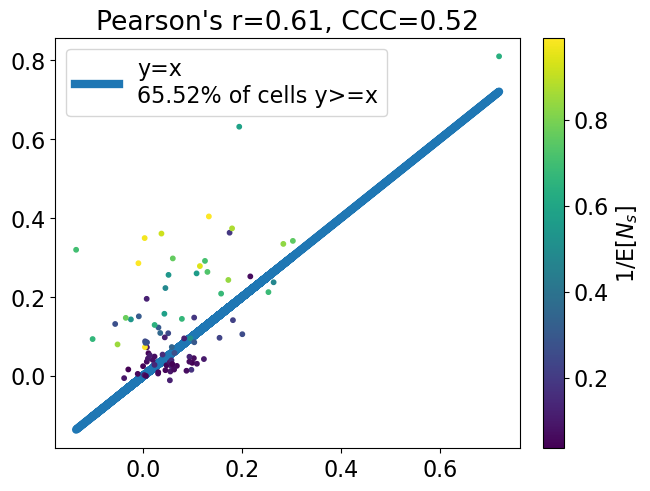

In [27]:
x=zeta_us
y=zeta_ss

plt.plot(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# D2

In [31]:
rna = ad.read_h5ad('/home/mffang/data/counts/Klein_2015/SRR1784313/counts_unfiltered/adata.h5ad')
rna

AnnData object with n_obs × n_vars = 80212 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

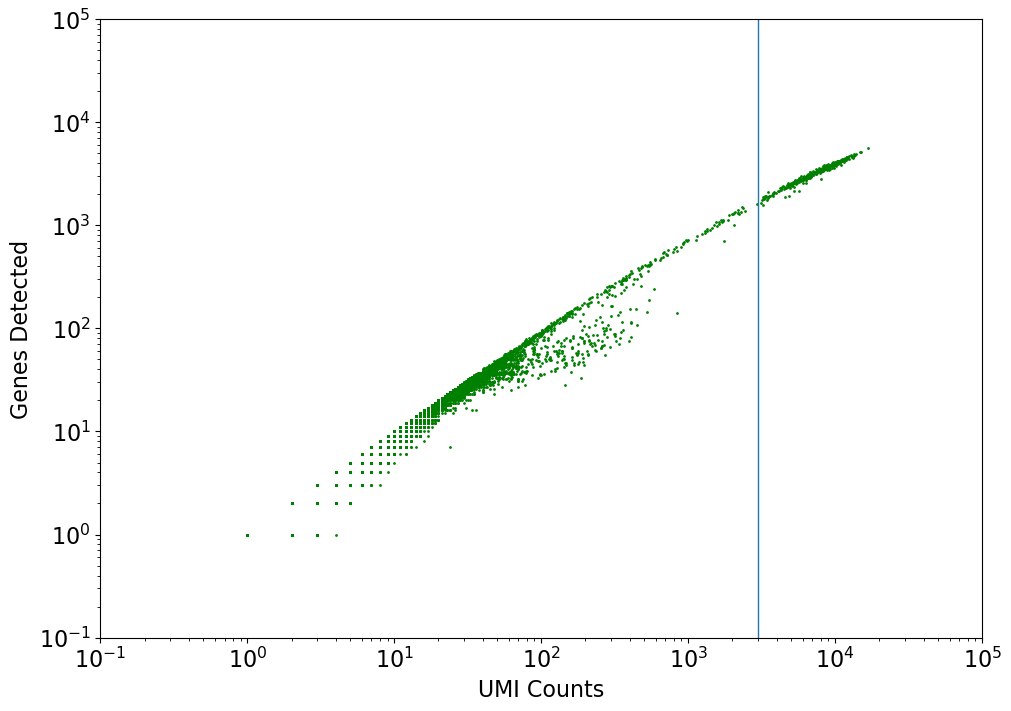

In [32]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=1, s=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=3000,linewidth=1)
plt.show()

In [33]:
adata = rna[np.asarray(mtx.sum(axis=1))>3000]
adata

View of AnnData object with n_obs × n_vars = 292 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

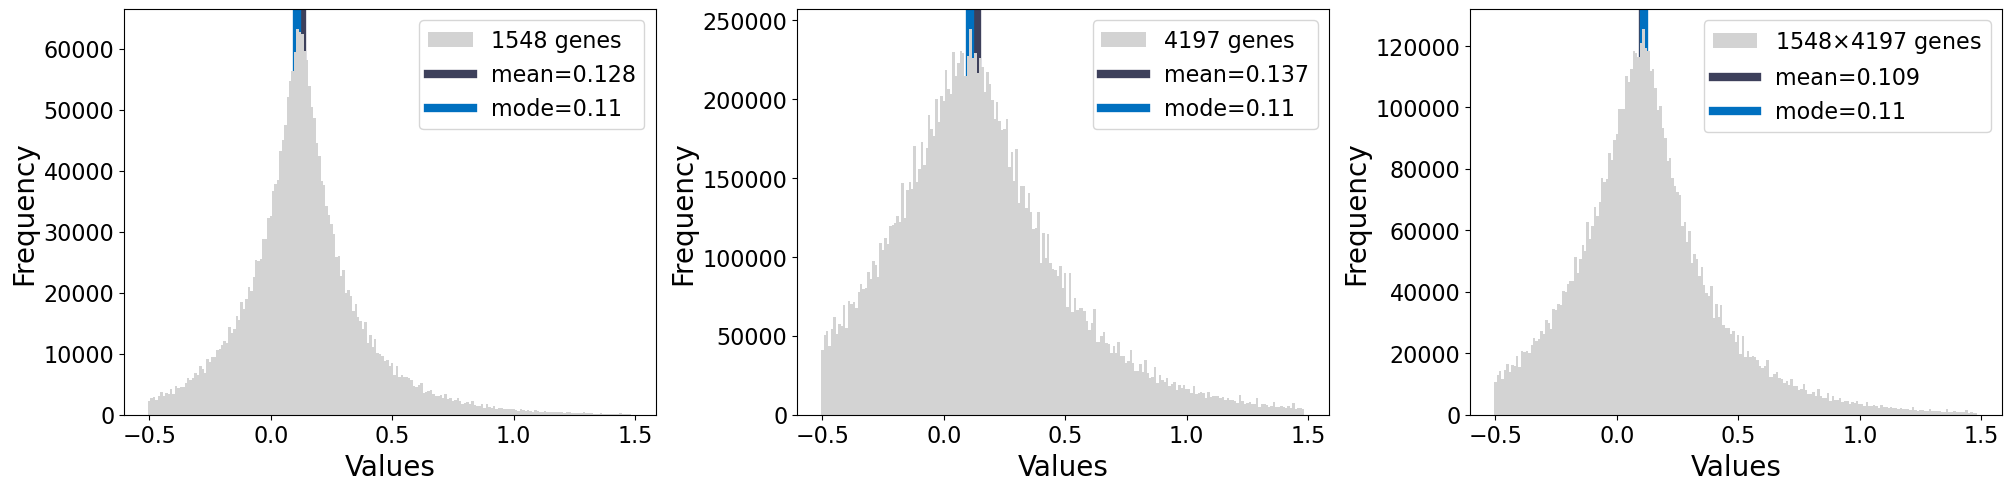

In [34]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

100%|██████████| 1000/1000 [00:07<00:00, 127.07it/s]


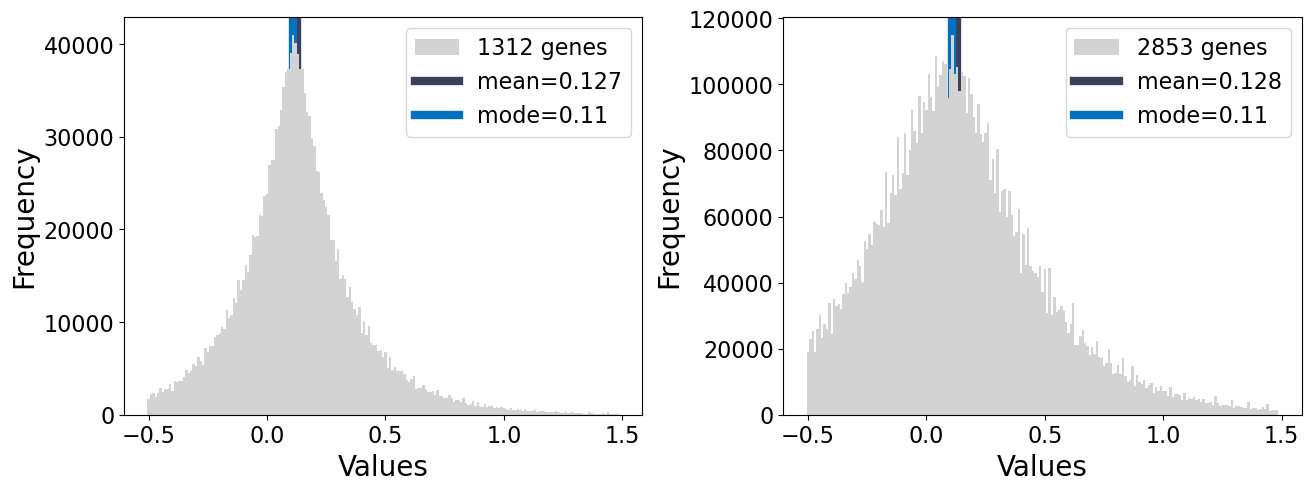

In [35]:
ss = 0.11
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_ss = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

su = 0.11
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

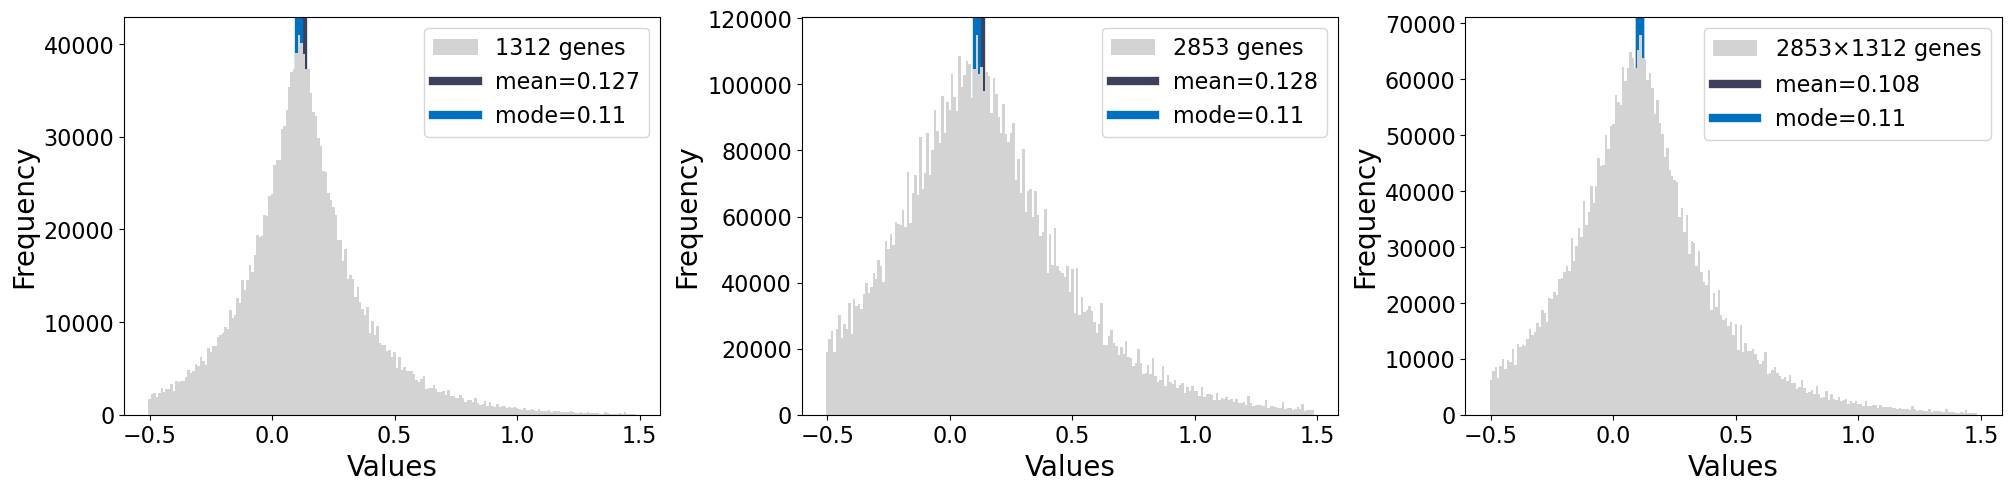

In [36]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

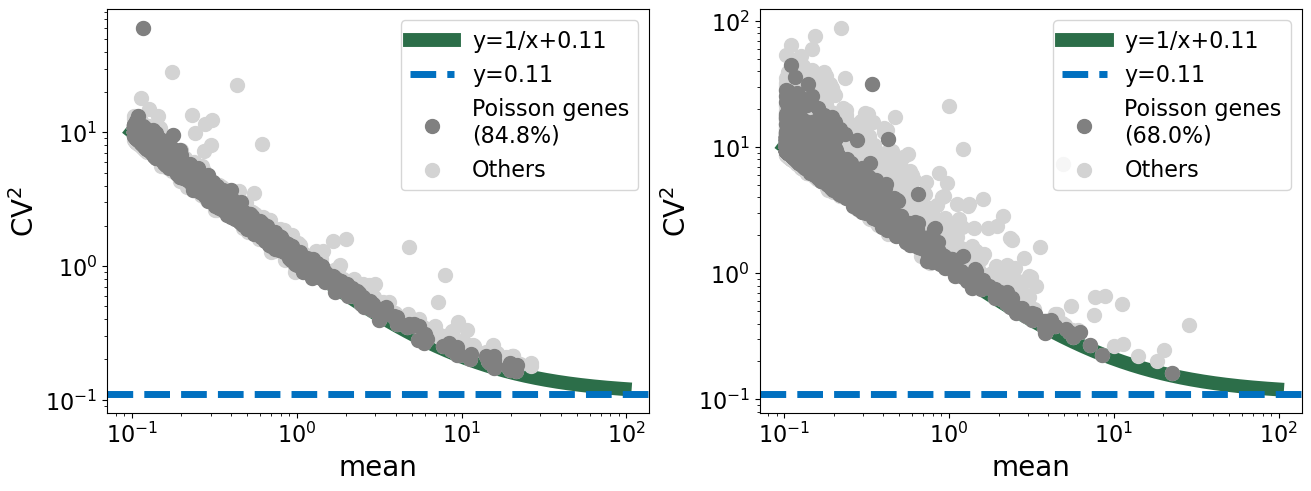

In [37]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))
x = 10**np.arange(-1,2,0.01)

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(S_Pgene)

ax[0].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[0].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(U_Pgene)

ax[1].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[1].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[1].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

In [39]:
D2_Pgenes = S_Pgene.copy()
D2_Pgenes

Index(['ENSMUSG00000039748.12', 'ENSMUSG00000041763.15',
       'ENSMUSG00000026500.7', 'ENSMUSG00000026245.17',
       'ENSMUSG00000039630.11', 'ENSMUSG00000025917.10',
       'ENSMUSG00000042699.12', 'ENSMUSG00000033701.14',
       'ENSMUSG00000026496.12', 'ENSMUSG00000038806.8',
       ...
       'ENSMUSG00000041133.12', 'ENSMUSG00000031297.15',
       'ENSMUSG00000031311.18', 'ENSMUSG00000001134.10',
       'ENSMUSG00000002015.6', 'ENSMUSG00000002010.18',
       'ENSMUSG00000031388.15', 'ENSMUSG00000001962.9',
       'ENSMUSG00000015290.16', 'ENSMUSG00000095041.8'],
      dtype='object', name='gene_id', length=1312)

# D4

In [22]:
rna = ad.read_h5ad('/home/mffang/data/counts/Klein_2015/SRR1784314/counts_filtered/adata.h5ad')
rna

AnnData object with n_obs × n_vars = 710 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

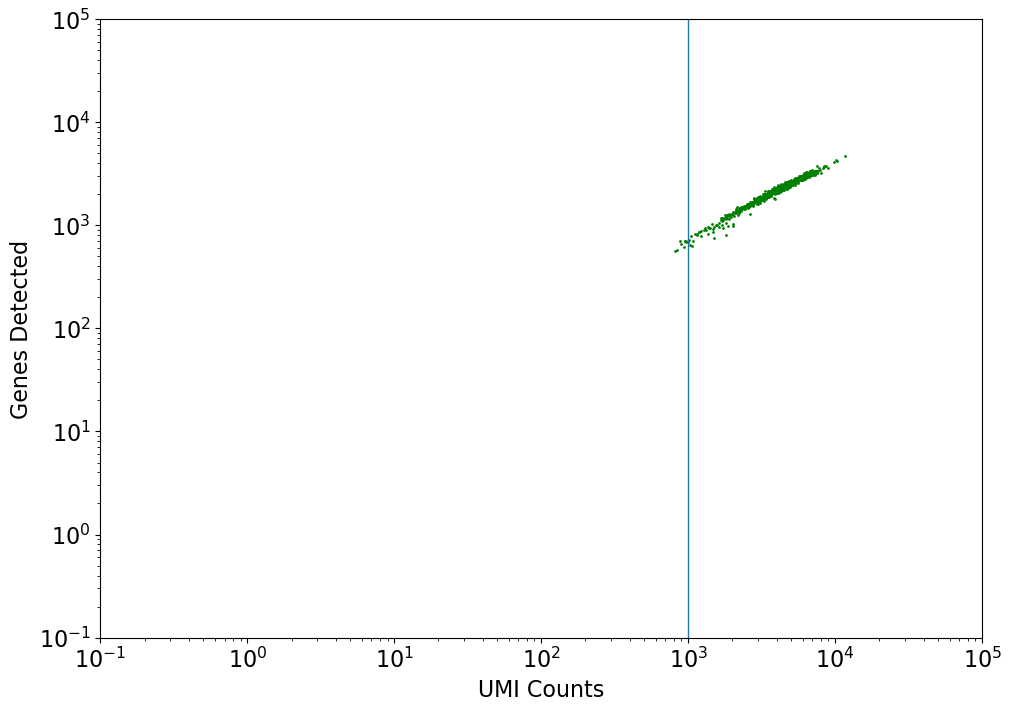

In [23]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=1, s=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=1000,linewidth=1)
plt.show()

In [24]:
adata = rna[np.asarray(mtx.sum(axis=1))>1000]
adata

View of AnnData object with n_obs × n_vars = 701 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

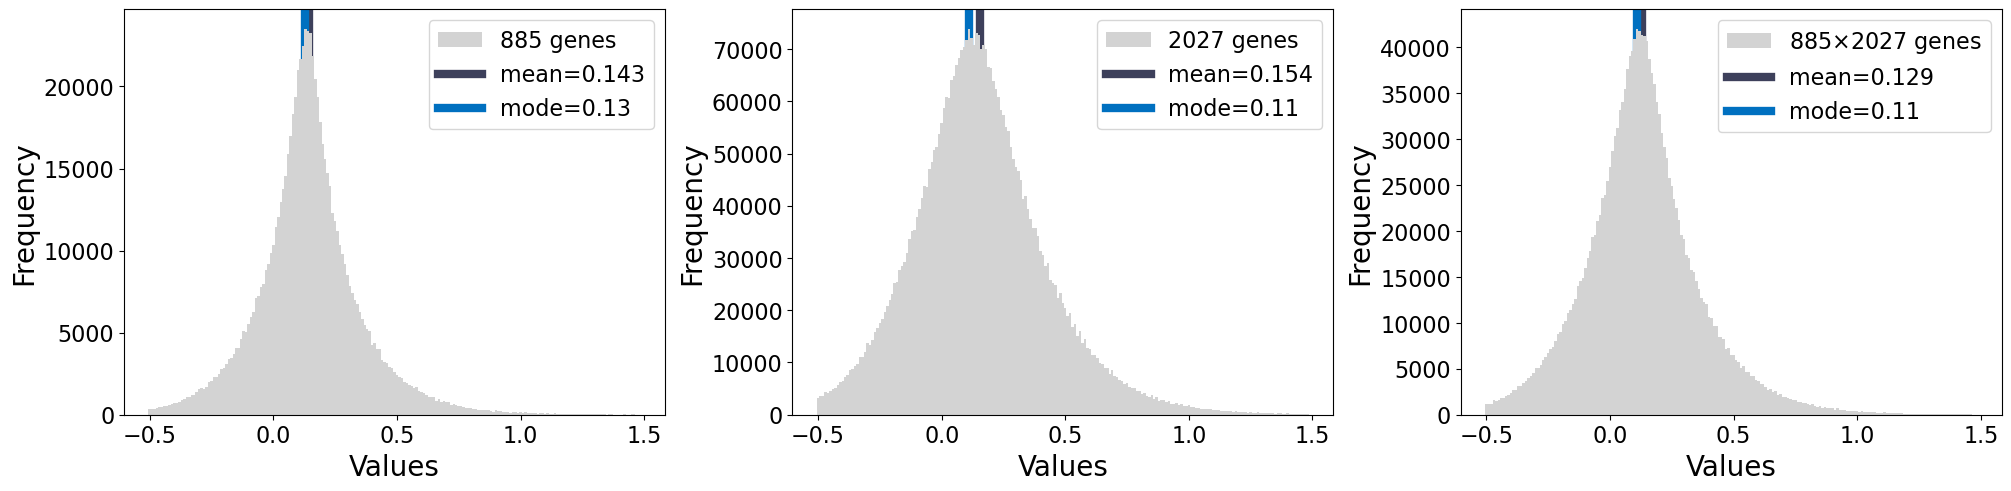

In [25]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

100%|██████████| 1000/1000 [00:08<00:00, 121.11it/s]


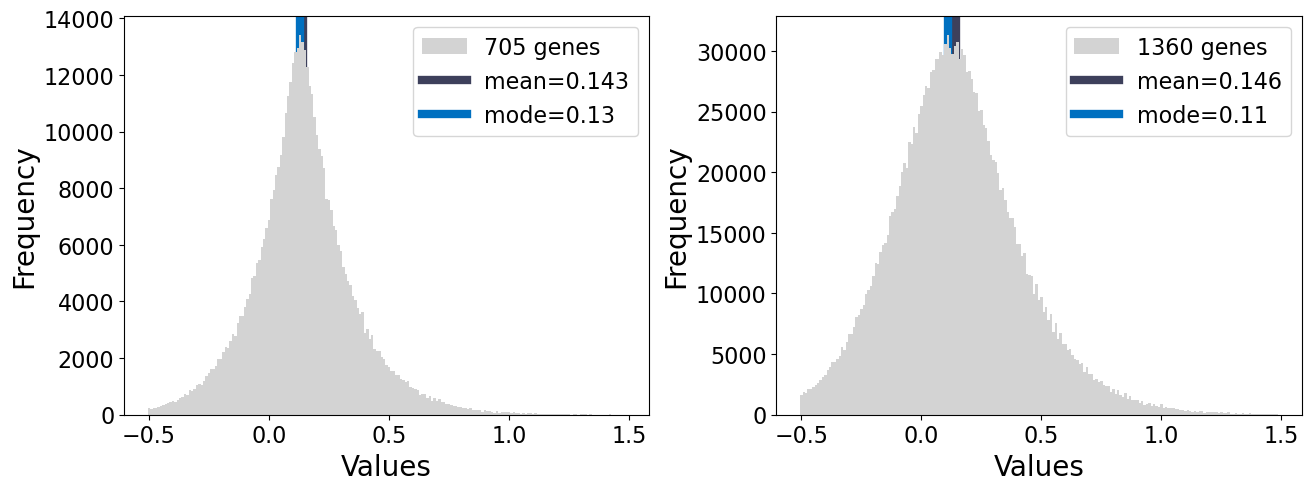

In [26]:
ss = 0.13
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_ss = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

su = 0.11
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

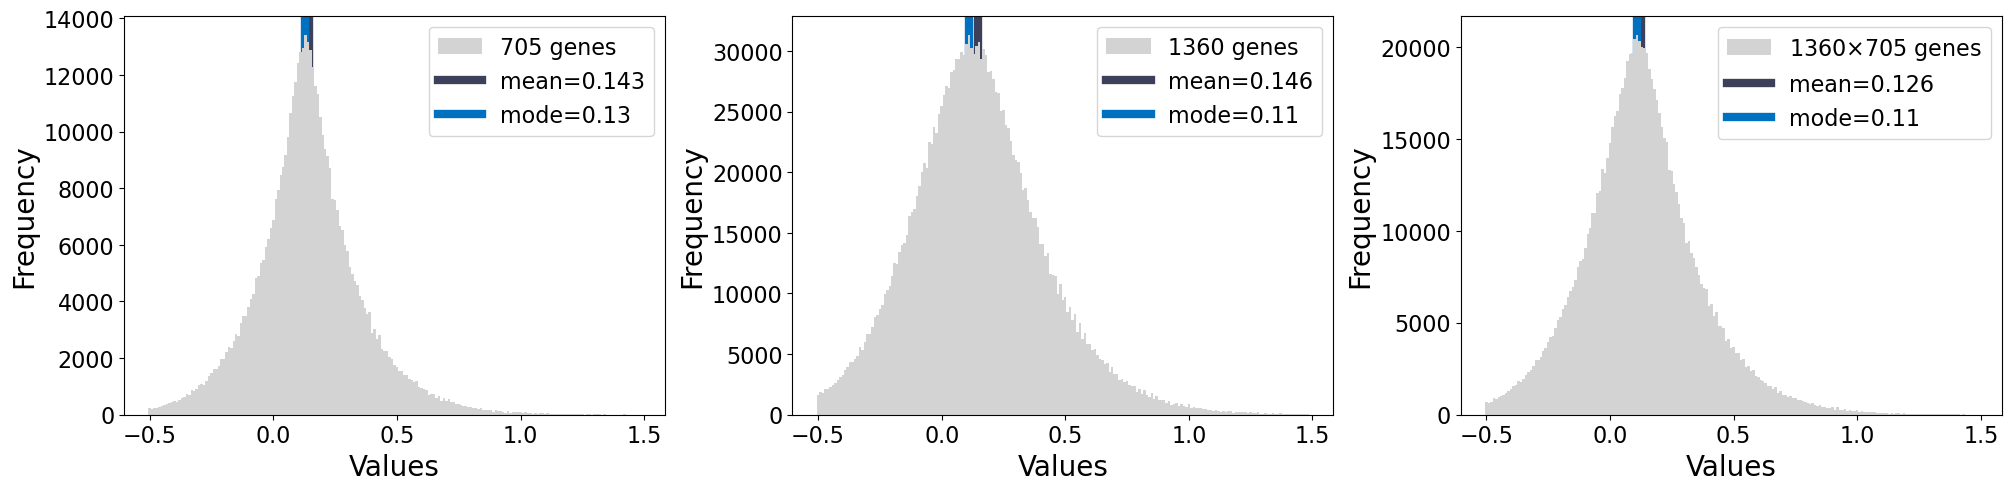

In [27]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

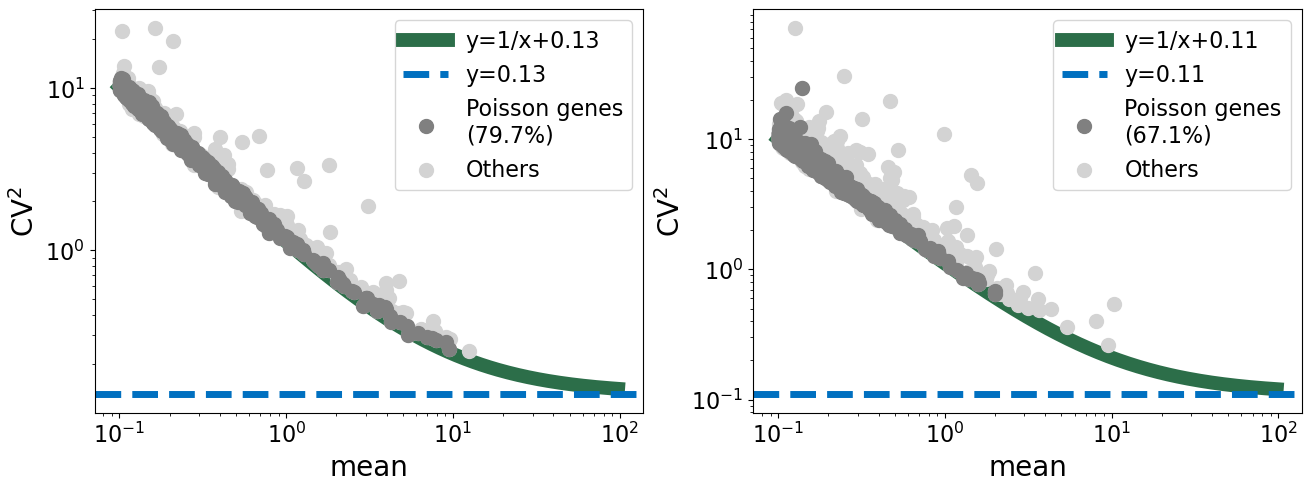

In [28]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))
x = 10**np.arange(-1,2,0.01)

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(S_Pgene)

ax[0].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[0].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(U_Pgene)

ax[1].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[1].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[1].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

In [29]:
D4_Pgenes = S_Pgene.copy()
D4_Pgenes

Index(['ENSMUSG00000026245.17', 'ENSMUSG00000039630.11',
       'ENSMUSG00000025917.10', 'ENSMUSG00000062169.14',
       'ENSMUSG00000038733.15', 'ENSMUSG00000001674.12',
       'ENSMUSG00000026341.17', 'ENSMUSG00000079658.10',
       'ENSMUSG00000025982.14', 'ENSMUSG00000025980.15',
       ...
       'ENSMUSG00000049775.17', 'ENSMUSG00000079480.4',
       'ENSMUSG00000031320.10', 'ENSMUSG00000050197.6',
       'ENSMUSG00000001924.16', 'ENSMUSG00000062170.13',
       'ENSMUSG00000051257.4', 'ENSMUSG00000041133.12',
       'ENSMUSG00000002010.18', 'ENSMUSG00000002014.13'],
      dtype='object', name='gene_id', length=705)

# D7

In [9]:
rna = ad.read_h5ad('/home/mffang/data/counts/Klein_2015/SRR1784315/counts_unfiltered/adata.h5ad')
rna

AnnData object with n_obs × n_vars = 138015 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

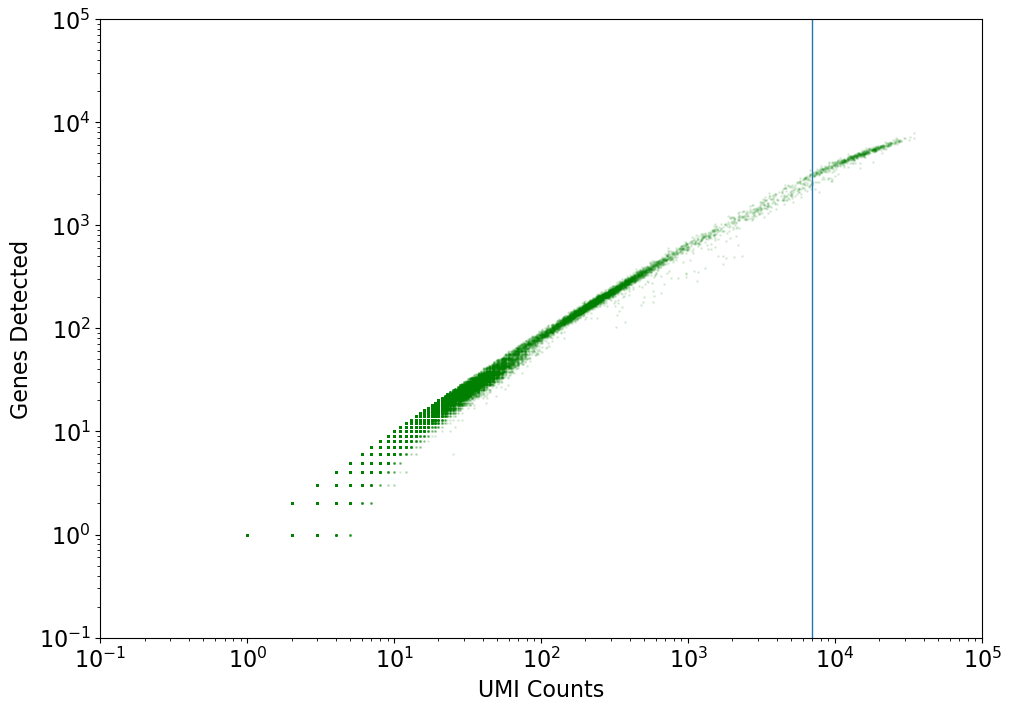

In [10]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.1, s=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=7000,linewidth=1)
plt.show()

In [11]:
adata = rna[np.asarray(mtx.sum(axis=1))>7000]
adata

View of AnnData object with n_obs × n_vars = 572 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

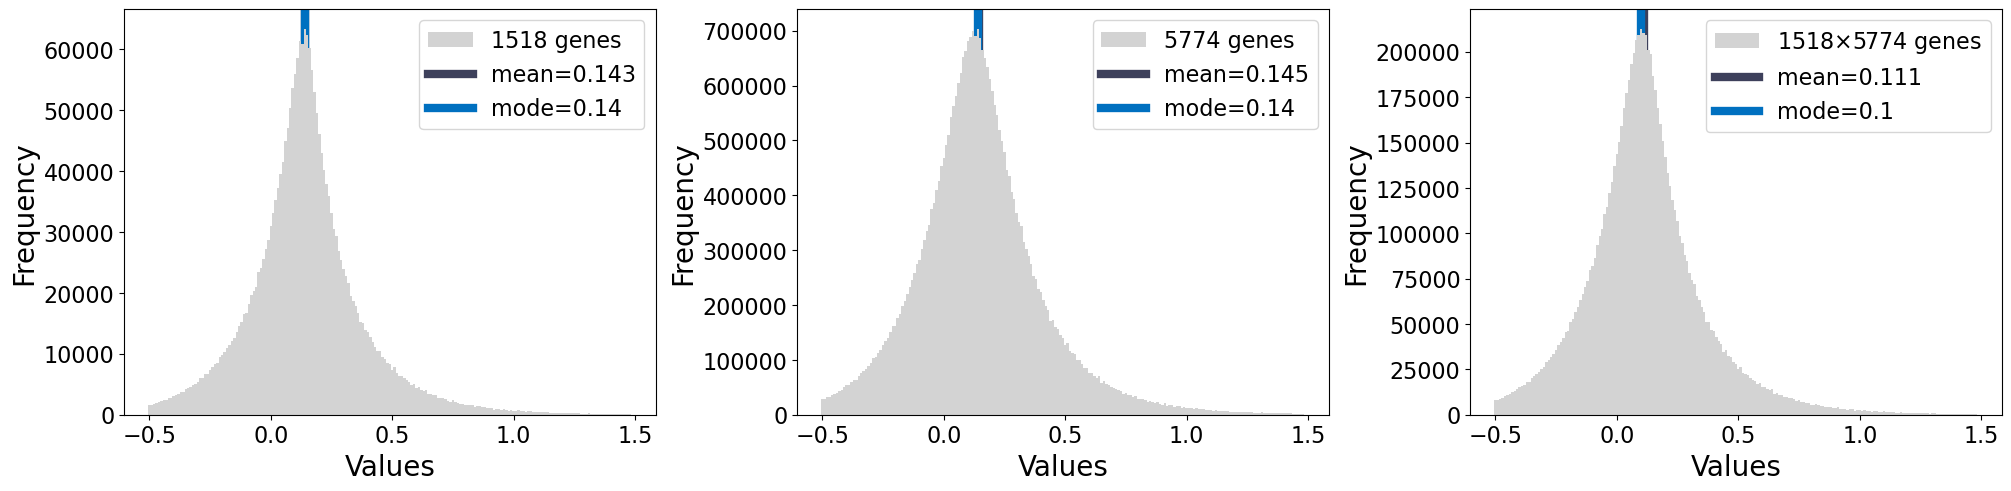

In [12]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s]


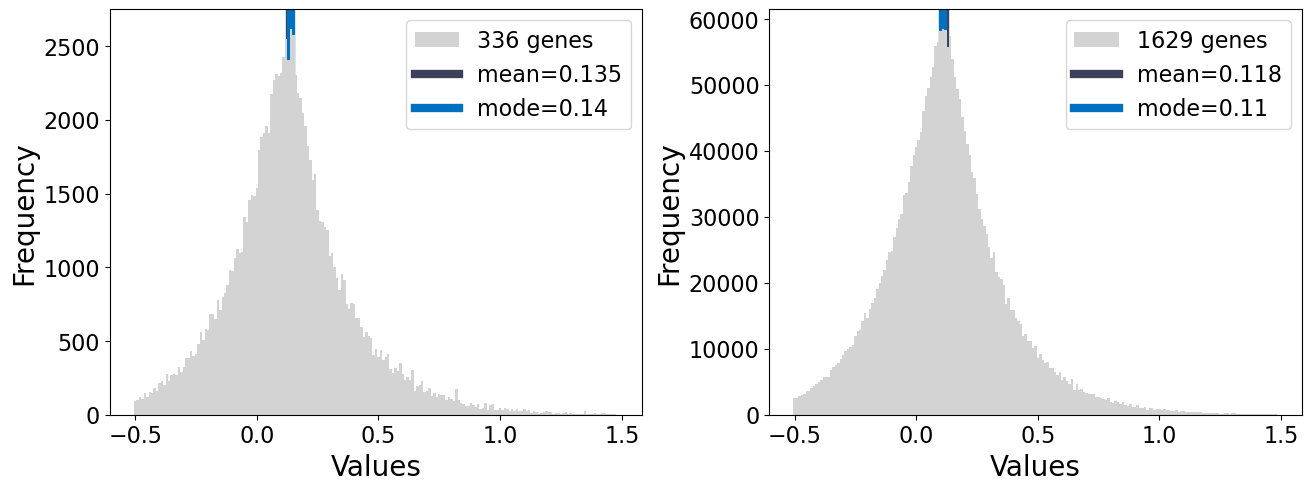

In [14]:
ss = 0.14
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_ss = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

su = 0.14
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

100%|██████████| 1000/1000 [00:17<00:00, 57.02it/s]


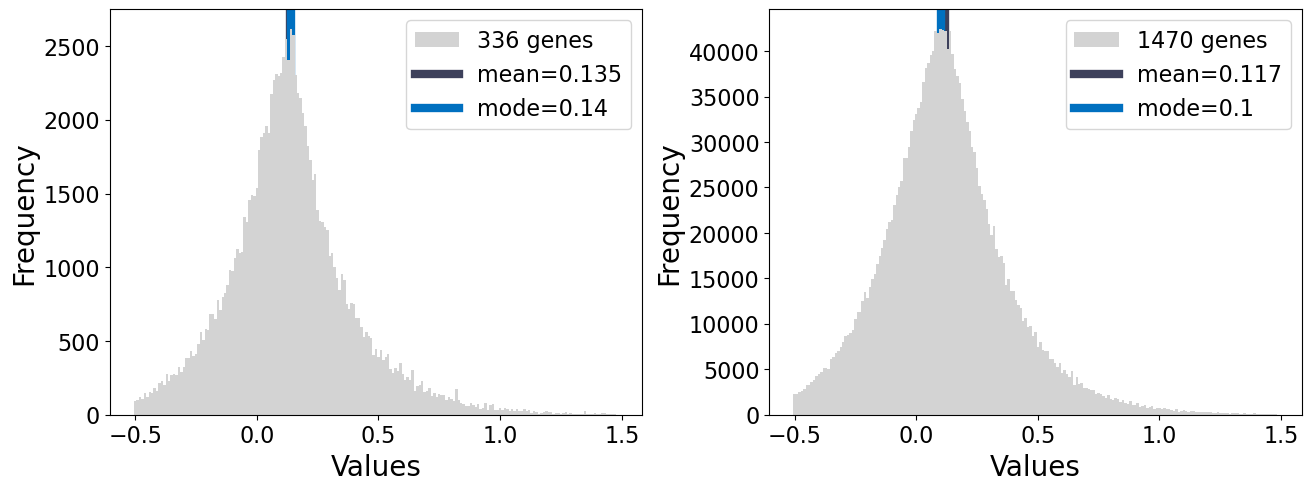

In [18]:
su = 0.1
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound, bootstrap_su = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
U_Pgene_mask = (su < upper_bound) & (su > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,2,figsize=(13,4.8))

idx = adata.var_names.isin(S_Pgene)
X_ = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_ = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

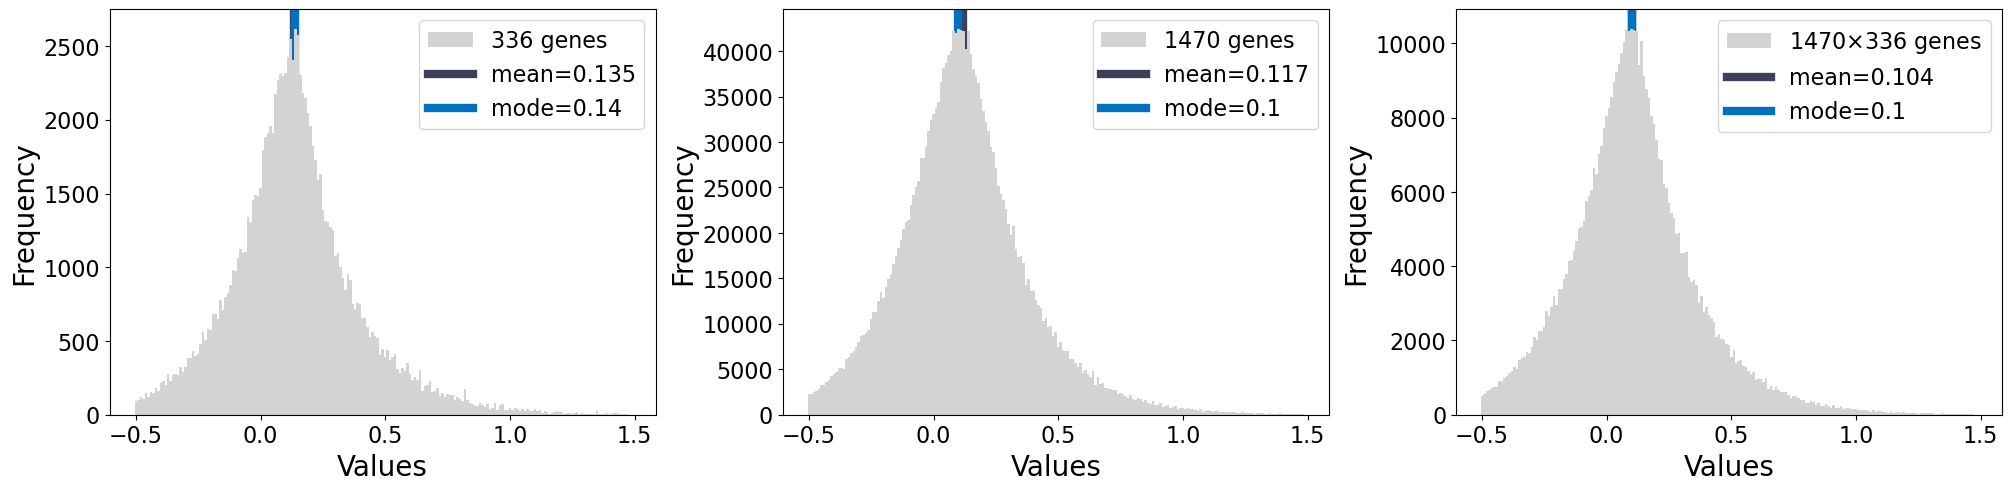

In [19]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0],min_mean=0.1,var_threshold=np.inf,n_iter=0)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1],min_mean=0.1,var_threshold=np.inf,n_iter=0)

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2],min_mean=0.1,var_threshold=np.inf,n_iter=0)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

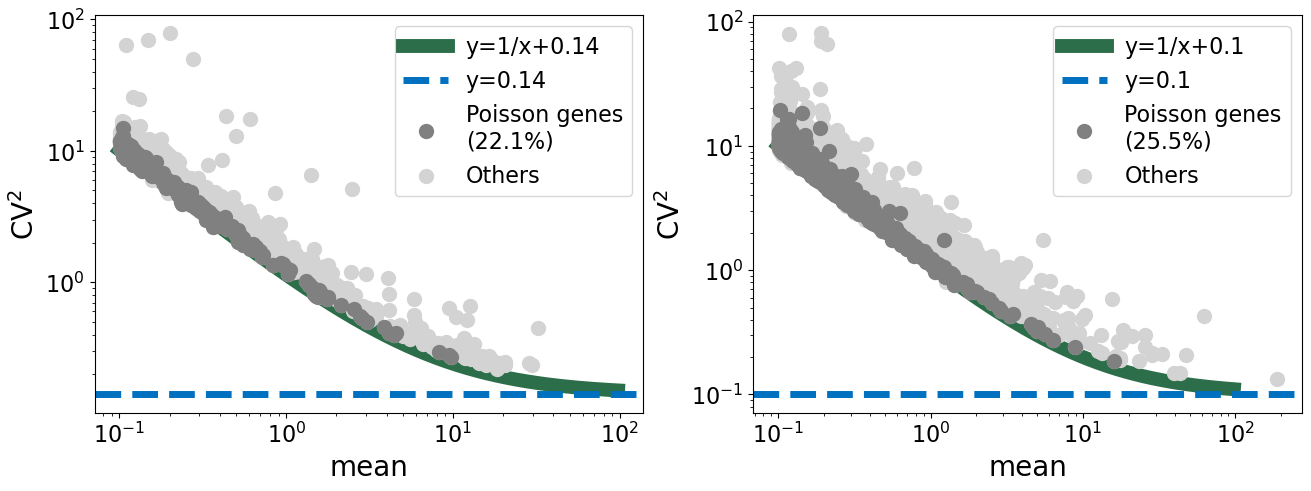

In [20]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))
x = 10**np.arange(-1,2,0.01)

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(S_Pgene)

ax[0].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[0].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = adata.var_names[nonzero_idx].isin(U_Pgene)

ax[1].plot(x, 1/x + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,3)))
ax[1].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[1].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

In [21]:
D7_Pgenes = S_Pgene.copy()
D7_Pgenes

Index(['ENSMUSG00000018417.15', 'ENSMUSG00000026496.12',
       'ENSMUSG00000025935.11', 'ENSMUSG00000073676.5',
       'ENSMUSG00000073481.10', 'ENSMUSG00000026155.14',
       'ENSMUSG00000026019.16', 'ENSMUSG00000061518.12',
       'ENSMUSG00000026083.13', 'ENSMUSG00000073702.12',
       ...
       'ENSMUSG00000031229.17', 'ENSMUSG00000016427.8',
       'ENSMUSG00000025268.16', 'ENSMUSG00000000355.14',
       'ENSMUSG00000025261.19', 'ENSMUSG00000079435.10',
       'ENSMUSG00000050071.9', 'ENSMUSG00000031370.13', 'ENSMUSG00000079480.4',
       'ENSMUSG00000015290.16'],
      dtype='object', name='gene_id', length=336)

# P genes

In [30]:
len(np.intersect1d(D7_Pgenes,D4_Pgenes)),len(D7_Pgenes),len(D4_Pgenes)

(138, 336, 705)

In [40]:
len(np.intersect1d(D2_Pgenes,D7_Pgenes)),len(D7_Pgenes),len(D2_Pgenes)

(230, 336, 1312)

In [55]:
len(np.intersect1d(D0_Pgenes,D7_Pgenes)),len(D7_Pgenes),len(D0_Pgenes)

(64, 336, 184)

In [56]:
len(np.intersect1d(np.intersect1d(np.intersect1d(D0_Pgenes,D2_Pgenes),D4_Pgenes),D7_Pgenes))

29